# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
using Base.Threads
println("Usando ", nthreads(), " threads 😎")

Usando 1 threads 😎


In [2]:
import Pkg
Pkg.activate("../")
Pkg.instantiate()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`


In [3]:
import Pkg; Pkg.add(["Revise", "GLMakie"])

   Resolving package versions...
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Project.toml`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Manifest.toml`


In [4]:
using Revise
using CellBasedModels
using CUDA
using Distributions
using GLMakie
# using GeometryBasics
import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187


## Forces model

We already use the defined forces model that is implemented in CBqodels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [ ]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
        ),    #Local Interaction Parameters

    model = Dict(
            :E=>Float64,
            :eta=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,d,l,theta,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,1,l,theta,
                        x[i2],y[i2],1,l[i2],theta[i2],eta, E)

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a coqunity with two bacteries and check forces

In [6]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.E=100. *m/(t^2*d)*1.E-3 #kPa
com.eta=500 *m/(t*d) #Pa h


1.8000000000000003

In [7]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    com.l[i] = 3.0
    com.d[i] = 1.0

end

In [8]:
evolve!(com,steps=8000,saveEach=100,preallocateAgents=com.N)

In [9]:
function plotAgents2D!(ax, x, y, d, l, angle, p; kargs...)
    for (xi, yi, li, di, ai, pi) in zip(x, y, l, d, angle, p)



            colorval = pi
            colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )

    end
    return
end


plotAgents2D! (generic function with 1 method)

In [10]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

GLMakie.Screen(...)

In [11]:
using JSON

function log_coqunity_state(parameters::OrderedDict, t::Int, path::String = "parameters_QS_PGA.txt")
    # Convert keys to strings so JSON can serialize them
    string_keys = Dict(string(k) => v for (k, v) in parameters)
    # Build entry
    entry = Dict("t" => t, "parameters" => string_keys)
    # Save as a JSON line
    open(path, "a") do io
        println(io, JSON.json(entry))
    end
end


function load_parameters_log(path::String = "parameters_QS_PGA.txt")
    log = Dict{Int, OrderedDict{Symbol, Any}}()
    for line in eachline(path)
        entry = JSON.parse(line)
        t = entry["t"]
        raw_params = entry["parameters"]
        params = OrderedDict(Symbol(k) => v for (k, v) in raw_params)
        log[t] = params
    end
    times = sort(collect(keys(log)))
    com_array = [log[t] for t in times]
    return com_array, times
end



load_parameters_log (generic function with 2 methods)

In [12]:
steps=8000
saveEach=100
N=100
loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_PGA.txt", "w") do f
    # clear file at start
end


for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if  N - com.N[1] < 2*com.N[1]
            N = 4*com.N[1]
        end
        println("Step ",step, " N: ", com.N[1])
        log_coqunity_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end


Step 100 N: 30
Step 200 N: 30
Step 300 N: 30
Step 400 N: 30
Step 500 N: 30
Step 600 N: 30
Step 700 N: 30
Step 800 N: 30
Step 900 N: 30
Step 1000 N: 30
Step 1100 N: 30
Step 1200 N: 30
Step 1300 N: 30
Step 1400 N: 30
Step 1500 N: 30
Step 1600 N: 30
Step 1700 N: 30
Step 1800 N: 30
Step 1900 N: 30
Step 2000 N: 30
Step 2100 N: 30
Step 2200 N: 30
Step 2300 N: 30
Step 2400 N: 30
Step 2500 N: 30
Step 2600 N: 30
Step 2700 N: 30
Step 2800 N: 30
Step 2900 N: 30
Step 3000 N: 30
Step 3100 N: 30
Step 3200 N: 30
Step 3300 N: 30
Step 3400 N: 30
Step 3500 N: 30
Step 3600 N: 30
Step 3700 N: 30
Step 3800 N: 30
Step 3900 N: 30
Step 4000 N: 30
Step 4100 N: 30
Step 4200 N: 30
Step 4300 N: 30
Step 4400 N: 30
Step 4500 N: 30
Step 4600 N: 30
Step 4700 N: 30
Step 4800 N: 30
Step 4900 N: 30
Step 5000 N: 30
Step 5100 N: 30
Step 5200 N: 30
Step 5300 N: 30
Step 5400 N: 30
Step 5500 N: 30
Step 5600 N: 30
Step 5700 N: 30
Step 5800 N: 30
Step 5900 N: 30
Step 6000 N: 30
Step 6100 N: 30
Step 6200 N: 30
Step 6300 N: 30
S

In [13]:
com_,times=load_parameters_log("parameters_QS_PGA.txt")

(OrderedDict{Symbol, Any}[OrderedDict(:W => Any[6.236953903930555e-11, 1.7902113696660684e-11, -4.031872346860515e-11, -9.198171650947412e-13, 5.255802543567999e-10, 0.0, -7.033881969259825e-12, 5.3718497277199304e-12, -6.369790065478015e-10, 1.7358901888175635e-11  …  1.8134145432634494e-9, 1.230214675197929e-10, 1.7963110961701267e-11, 0.0, 9.306487908848037e-11, 6.00427778873816e-10, 0.0, 1.1542690892259438e-10, -2.73863238017381e-10, -6.705264880385736e-12], :fx => Any[-1.8791730703145084e-10, 4.0082518906479997e-10, -2.7652767007337096e-10, 2.7153177292578733e-11, 1.2472599681647585e-9, 0.0, -3.027824967212487e-10, -2.7153177292578733e-11, -1.219591357282029e-9, 3.932828140484126e-12  …  6.820419808610433e-10, -1.529573072880052e-10, -1.841195553584793e-10, 0.0, 3.0097483667709365e-9, 1.8171130730252642e-11, 0.0, -5.4461429597725935e-11, 1.6950488194518303e-9, 1.2473209412597884e-11], :x => Any[5.960835188720446, -2.8363846317949997, 3.624632262381039, -2.6704906132994677, 4.59843

In [14]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com_)/4):length(com_);length(com_)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com_[j][:x],
    com_[j][:y],
    com_[j][:d],
    com_[j][:l],
    com_[j][:theta],
    com_[j][:pressure],
    colorrange = (0, maximum((p[:pressure][1]) for p in com_))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

GLMakie.Screen(...)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [ ]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64,
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :K_p=>Float64,
                :K_q=>Float64,
                :D_q => Float64,
                :delta_q => Float64,
                :r_q => Float64, 
            ),
    
    medium = Dict(
        :q => Float64,        #Add a medium parameter
    ),

 
    agentODE = quote    
        dt(l) = l*growth/(1+K_p*pressure) #linear growth with growth dependent on the pressure over the cell
        dt(d) = d/(kd+d)*q/(Kq+q) #linear growth with growth dependent on the pressure over the cell

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin
            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,d,l,theta,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij
             #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,1,l,theta,
                                    x[i2],y[i2],1,l[i2],theta[i2],eta, E)

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end
        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)/10000 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget))
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww)
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing q with a saturating function
        pq = growth/(1+(K_p*pressure))
        if CBMDistributions.uniform(0, 1) < pq
            q += r_q
        end

        # Probability of releasing PGA with a saturating function
        pg = q/(q+K_q)
        if CBMDistributions.uniform(0, 1) < pg
            H += r_H
        end
    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(q) = D_q*(@∂2(1,q)+@∂2(2,q)) - delta_q*q 
        end

    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [173]:
com = Community(rods2dGrowth,
            N=1,
            dt=1.,
            simBox = [-50 50;-50 50.],
            NMedium=[100,100],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.E=20. *m/(t^2*d)*1.E-3 #kPa

com.eta=500 *m/(t*d) #Pa h

com.D_q = 1.E-5 /t #um^2/h
# com.D_H = 1.E-12 /t #um^2/h
com.D_H = 0. #um^2/h
com.delta_q = 1.E-10 
com.delta_H = 0. 
# com.delta_H = 1.E-5 

com.r_q = 1
com.r_H = 1


com.growth = 0.5 * t
com.lMax = 4.     
com.σlTarget = 1. 
com.K_p = 1000
com.K_q = 5000
 
com.d = 1.        
com.l = 3.99      
com.lTarget = 4.  
com.v = 2.E-2 


com.x = 0
com.y = 0
com.theta = 0;

In [ ]:
steps=100000
saveEach=5000
# steps=100000
# saveEach=10000
N=100 

loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_PGA.txt", "w") do f
    # clear file at start
end

for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_coqunity_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end

Step 5000 N: 2
Step 10000 N: 4
Step 15000 N: 5
Step 20000 N: 8
Step 25000 N: 16
Step 30000 N: 20
Step 35000 N: 31
Step 40000 N: 45
Step 45000 N: 56
Step 50000 N: 79
Step 55000 N: 96
Step 60000 N: 127
Step 65000 N: 157
Step 70000 N: 186
Step 75000 N: 234


In [ ]:
com_load,times=load_parameters_log("parameters_QS_PGA.txt")


(OrderedDict{Symbol, Any}[OrderedDict(:W => Any[-3.6062590896332668e-9, -3.6062590896332668e-9], :fx => Any[-0.00016263448103205502, 0.00016263448103205502], :delta_q => Any[1.0e-10], :x => Any[-1.8623031811563628, 1.8623031811563628], :K_p => Any[1000.0], :σlTarget => Any[1.0], :delta_H => Any[1.0e-5], :theta => Any[-1.7584435328051283e-5, -1.7584435328051283e-5], :r_H => Any[1.0], :D_H => Any[0.0]…), OrderedDict(:W => Any[0.0, 0.0, 0.0, 0.0], :fx => Any[0.0, 0.0, 0.0, 0.0], :delta_q => Any[1.0e-10], :x => Any[-3.416219361895603, 0.7539083969089129, 3.2393519240083983, -0.5754939016313528], :K_p => Any[1000.0], :σlTarget => Any[1.0], :delta_H => Any[1.0e-5], :theta => Any[-1.7370820969316967e-5, -0.08387273700844528, -2.1239092312194877e-5, -0.08387335378654691], :r_H => Any[1.0], :D_H => Any[0.0]…), OrderedDict(:W => Any[0.0, 7.746613479074807e-5, -1.1034633646261246e-5, -2.8574770821425062e-5, 0.0, 0.00012374931362210911], :fx => Any[0.0, -4.9746982731411165e-6, 2.0389885195839437e-

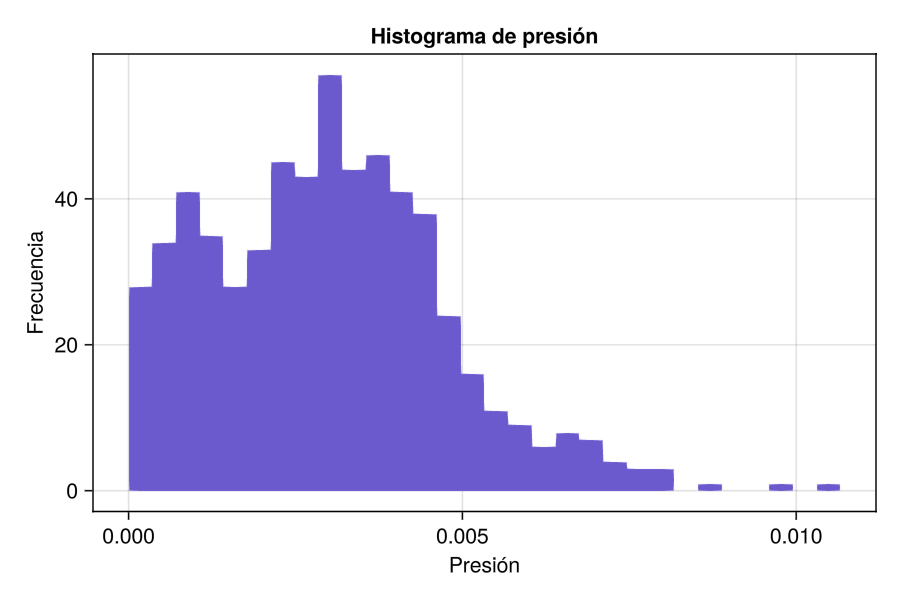

In [ ]:
# Elegimos un frame, por ejemplo el último
p = com_load[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [170]:
# Colormap común y colorrange fijo
colormap = :viridis
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

GLMakie.Screen(...)

In [30]:
# Colormap común y colorrange fijo
colormap = :viridis
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:pressure],
    # colorrange = (0, 0.03)
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

GLMakie.Screen(...)

In [ ]:
# Colormap común y colorrange fijo
colormap = Reverse(:Blues)
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:H]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.H)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.H)[1]),
                Float64.(hcat(com_load[j][:H]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "PGA"
)

display(fig)

GLMakie.Screen(...)

In [172]:
# Colormap común y colorrange fijo
colormap = Reverse(:Blues)
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:H]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.H)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.H)[1]),
                Float64.(hcat(com_load[j][:H]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:pressure],
    # colorrange = (0, 0.03)
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "PGA"
)

display(fig)

GLMakie.Screen(...)

In [163]:
# # Colormap común y colorrange fijo
# colormap = Reverse(:Blues)
# colorrange = (0.0,  maximum(maximum(p -> maximum(p[:H]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.H)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.H)[1]),
    #             Float64.(hcat(com_load[j][:H]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# # Añadir colorbar común al final
# Colorbar(fig[1, length(js) + 1],
#     colormap = colormap,
#     colorrange = colorrange,
#     label = "PGA"
# )

display(fig)

GLMakie.Screen(...)

In [87]:
# Colormap común y colorrange fijo
colormap = Reverse(:balance)
minval= minimum(minimum(p -> minimum(p[:Hx]), com_load))
maxval= maximum(maximum(p -> maximum(p[:Hx]), com_load))
maxrange= maximum(abs.([minval, maxval]))
colorrange = (-maxrange, maxrange)

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.Hx)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.Hx)[1]),
                Float64.(hcat(com_load[j][:Hx]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:pressure],
    # colorrange = (0, 0.03)
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "PGA"
)

display(fig)

GLMakie.Screen(...)

In [86]:
# Colormap común y colorrange fijo
colormap = Reverse(:balance)
minval= minimum(minimum(p -> minimum(p[:Hy]), com_load))
maxval= maximum(maximum(p -> maximum(p[:Hy]), com_load))
maxrange= maximum(abs.([minval, maxval]))
colorrange = (-maxrange, maxrange)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.Hy)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.Hy)[1]),
                Float64.(hcat(com_load[j][:Hy]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:pressure],
    # colorrange = (0, 0.03)
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "PGA"
)

display(fig)

GLMakie.Screen(...)

In [ ]:

# Configuración general
colormap = :viridis
colorrange = (0.0, maximum(com.q))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



Makie.record(fig, "bacterias_video_QS_PGA.mp4", 1:length(com_load); framerate = 15) do j
 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotMixedAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:type],
        com_load[j][:pressure],
        colorrange = (0, 0.03)
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


In [134]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0.0, maximum(com.H))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



Makie.record(fig, "bacterias_video_QS_PGA.mp4", 1:length(com_load); framerate = 15) do j
 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:pressure],
        colorrange = (0, 0.03)
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_video_QS_PGA.mp4"

In [ ]:


# Configuración general
colormap = :viridis
colorrange = (0.0, maximum(com.q))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



GLMakie.record(fig, "bacterias_video_pressure_qs_2_proves.mp4", 1:length(com_load); framerate = 15) do j
 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    # plotMixedAgents2D!(
    #     ax,
    #     com_load[j][:x],
    #     com_load[j][:y],
    #     com_load[j][:d],
    #     com_load[j][:l],
    #     com_load[j][:theta],
    #     com_load[j][:type],
    #     com_load[j][:pressure],
    #     colorrange = (0, 0.03)
    # )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_video_pressure_qs_2_proves.mp4"